In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import os
import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
import tensorflow as tf
import graphviz
import pydot
import sys
import skimage

In [2]:
import numpy as np
import pandas as pd

In [3]:
sys.path.insert(0, '..')
from function import create_new_folder

In [4]:
#generate a dataset
train_path = r'..\images'
test_path=r'..\sample_test_images'

In [5]:
df = pd.read_csv(r'..\data\sample_train.csv')
df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [9]:
#list(df.label.unique())

['Abstract Expressionism', 'Impressionism', 'Pop Art']

In [6]:
#filter any corrupt data
from PIL import Image

def delete_corrupt_image(image_path):
    num_skipped = 0

    for folder_name in os.listdir(image_path):
        folder_path = os.path.join(image_path, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                img = Image.open(fpath) #open and read images in file path
                img.verify() #verify this is an image
            except(IOError, SyntaxError) as e:
                print(f'Bad file: {fname}')
                num_skipped+=1
                # Delete corrupted image
                os.remove(fpath)

    print(f'Deleted {num_skipped} images')

In [8]:
delete_corrupt_image(train_path)
delete_corrupt_image(test_path)

Deleted 0 images
Deleted 0 images


In [162]:
image_size = (200, 200) #(height, width)
batch_size = 32
num_classes = len(os.listdir(train_path))

from keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(rotation_range=40, 
                                   width_shift_range=0.5,
                                   height_shift_range=0.5, 
                                   brightness_range=(0.1, 1.0),
                                   rescale=1./255, 
                                   shear_range=0.5,
                                   zoom_range=0.5,
                                   horizontal_flip=True, 
                                   fill_mode='reflect',  #figure out difference between nearest and reflect
                                   validation_split = 0.2)

train_generator = img_gen.flow_from_directory(directory=train_path, 
                                              target_size=image_size,
                                              classes=list(df.label.unique()),
                                              class_mode='categorical', 
                                              batch_size = batch_size,
                                              subset='training',
                                              shuffle=False,
                                              seed=42)

validation_generator = img_gen.flow_from_directory(directory=train_path, 
                                                   target_size=image_size,
                                                   classes=list(df.label.unique()),
                                                   class_mode='categorical', 
                                                   batch_size = batch_size,
                                                   subset='validation',
                                                   shuffle=False,
                                                   seed=42)

test_generator = img_gen.flow_from_directory(directory=test_path, 
                                                   target_size=image_size,
                                                   classes=list(df.label.unique()),
                                                   class_mode='categorical', 
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   seed=42)

Found 505 images belonging to 3 classes.
Found 125 images belonging to 3 classes.
Found 157 images belonging to 3 classes.


{'Abstract Expressionism': 0, 'Impressionism': 1, 'Pop Art': 2}

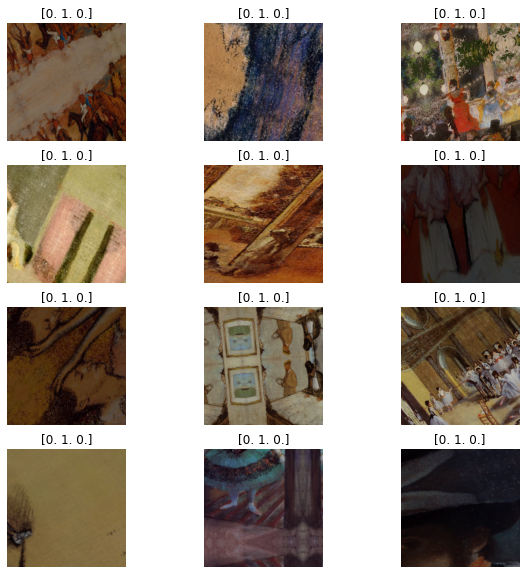

In [18]:
#visualize some of the data
from keras.preprocessing.image import array_to_img, img_to_array, load_img

plt.figure(figsize=(10, 10))

x, y = train_generator.next() 
#x is a numpy array of the img, y is the one-hot encode labels

for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    image = x[i]
    plt.imshow(image)
    plt.title(y[i])
    plt.axis("off")
    
train_generator.class_indices

In [ ]:
#add weights to model

In [10]:
import scipy as sp
import seaborn as sns
import sklearn as sk
import cv2
from keras import layers

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils

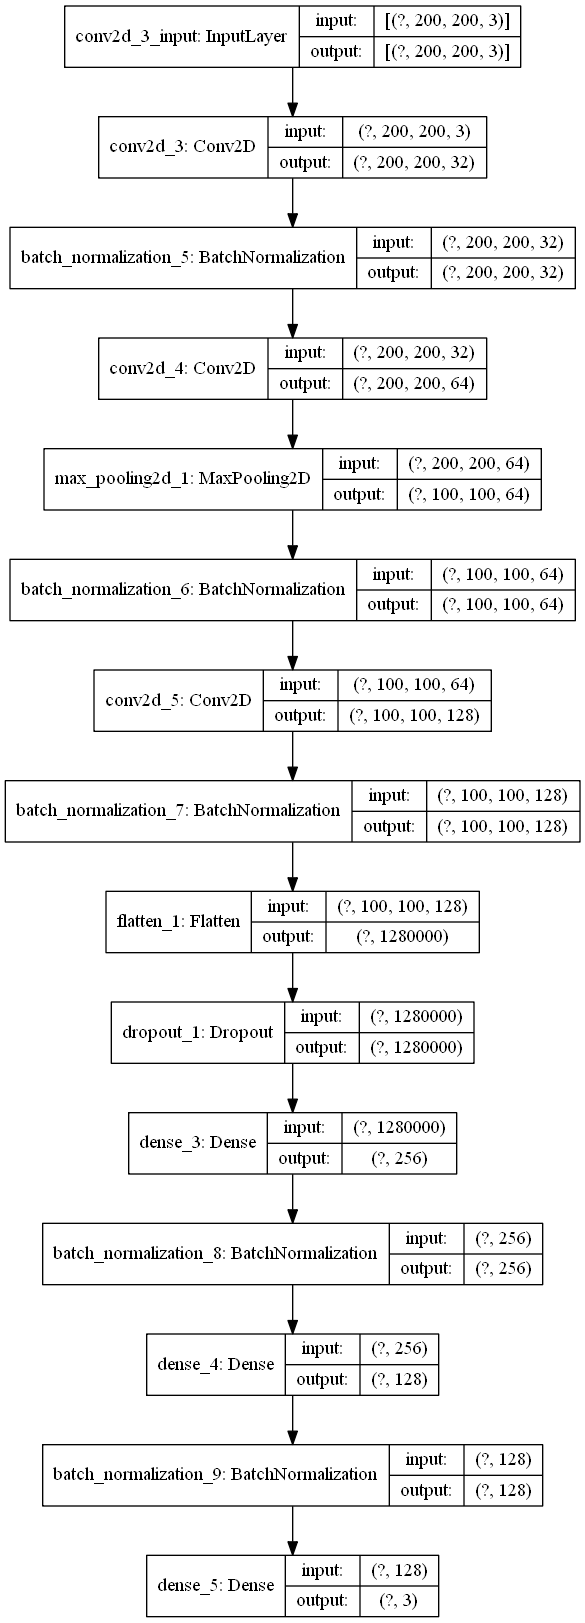

In [15]:
#sequential model for CNN
def sequential_model(input_shape, num_classes):
    #create a dense layer?
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'))
    #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(2))
    #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
    #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(256, kernel_constraint=maxnorm(3), activation='relu'))
    #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(128, kernel_constraint=maxnorm(3), activation='relu'))
    #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

model = sequential_model(input_shape=image_size + (3,), num_classes=num_classes)
keras.utils.plot_model(model, show_shapes=True)

In [123]:
modelpath = r'../models/model'
epochs = 10

In [17]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_sequential_checkpoint_{epochs}.h5')),]

model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']#, 'precision', 'recall'],
                 )

model.fit(train_generator,
              epochs=epochs,
              callbacks=callbacks,
              validation_data=validation_generator,)#try train_data, train_labels from train_generator?

print(model.summary())

Epoch 1/10
16/16 [==============================] - 537s 34s/step - loss: 1.6804 - accuracy: 0.3802 - val_loss: 0.9484 - val_accuracy: 0.7360
Epoch 2/10
16/16 [==============================] - 657s 41s/step - loss: 0.9700 - accuracy: 0.6238 - val_loss: 0.8753 - val_accuracy: 0.6800
Epoch 3/10
16/16 [==============================] - 599s 37s/step - loss: 0.8676 - accuracy: 0.7861 - val_loss: 0.7381 - val_accuracy: 0.7360
Epoch 4/10
16/16 [==============================] - 537s 34s/step - loss: 0.7775 - accuracy: 0.8574 - val_loss: 0.5888 - val_accuracy: 0.8720
Epoch 5/10
16/16 [==============================] - 379s 24s/step - loss: 0.6999 - accuracy: 0.8733 - val_loss: 0.5559 - val_accuracy: 0.8720
Epoch 6/10
16/16 [==============================] - 419s 26s/step - loss: 0.6266 - accuracy: 0.8634 - val_loss: 0.5800 - val_accuracy: 0.8720
Epoch 7/10
16/16 [==============================] - 521s 33s/step - loss: 0.5788 - accuracy: 0.8693 - val_loss: 0.5178 - val_accuracy: 0.8720
Epoch 

In [19]:
model.evaluate(validation_generator)

4/4 [==============================] - 4s 1s/step - loss: 0.4458 - accuracy: 0.8720


[0.44583937525749207, 0.871999979019165]

In [21]:
test_generator.reset()
pred = model.predict(test_generator, verbose=1)

5/5 [==============================] - 5s 1s/step


In [24]:
predicted_class_indices=np.argmax(pred,axis=1)

In [26]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [27]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
#results.to_csv("seq_results.csv",index=False)

In [30]:
results.Predictions.value_counts()

Impressionism    157
Name: Predictions, dtype: int64

In [54]:
from keras.initializers import glorot_uniform

In [163]:
#RESNET50
def identity_block(x, f, filters, stage, block):
    '''
    Identity Block for ResNet
    
    Arguments:
    x - input tensor of shape (samples, height, width, channel)
    f - int, specifies shape of middle Conv2D layer
    filters - list of ints; number of filters for each CONV layer in the main path
    stage - int, used to name layers by position in network
    block - str, used to name layers by position in network
    
    Returns:
    x - output of identity block with shape (samples_new, height_new, width_new, channel_new)
    
    '''
    
    #define names
    conv_name = f'res{stage}{block}'
    bn_name = f'bn{stage}{block}'
    
    #extract filters from list
    f1, f2, f3 = filters
    
    #save input value to add back to main path
    x_input = x
    
    #First block of main path
    x = layers.Conv2D(f1, kernel_size=1, strides=1, padding='valid', name=conv_name+'2a')(x)
    x = layers.BatchNormalization(name=bn_name+'2a')(x)
    x = layers.Activation('relu')(x)
    
    #Second block of main path
    x = layers.Conv2D(f2, kernel_size=f, strides=1, padding='same', name=conv_name+'2b')(x)
    x = layers.BatchNormalization(name=bn_name+'2b')(x)
    x = layers.Activation('relu')(x)
    
    #Third block of main path
    x = layers.Conv2D(f3, kernel_size=1, strides=1, padding='valid', name=conv_name+'2c')(x)
    x = layers.BatchNormalization(name=bn_name+'2c')(x)
    
    #input added back to main path and passed through a RELU activation
    x = layers.Add()([x, x_input])
    x = layers.Activation('relu')(x)
    
    return x

In [164]:
def convolutional_block(x, f, filters, stage, block, s=2):
    '''
    Convolutional Block for ResNet
    
    Arguments:
    x - input tensor of shape (samples, height, width, channel)
    f - int, specifies shape of middle Conv2D layer
    filters - list of ints; number of filters for each CONV layer in the main path
    stage - int, used to name layers by position in network
    block - str, used to name layers by position in network
    
    Returns:
    x - output of identity block with shape (samples_new, height_new, width_new, channel_new)
    
    '''
    
    #define names
    conv_name = f'res{stage}{block}'
    bn_name = f'bn{stage}{block}'
    
    #extract filters from list
    f1, f2, f3 = filters
    
    #save input value to add back to main path
    x_input = x
    
    #First block of main path
    x = layers.Conv2D(f1, kernel_size=1, strides=s, name=conv_name+'2a')(x)
    x = layers.BatchNormalization(name=bn_name+'2a')(x)
    x = layers.Activation('relu')(x)
    
    #Second block of main path
    x = layers.Conv2D(f2, kernel_size=f, strides=1, padding='same', name=conv_name+'2b')(x)
    x = layers.BatchNormalization(name=bn_name+'2b')(x)
    x = layers.Activation('relu')(x)
    
    #Third block of main path
    x = layers.Conv2D(f3, kernel_size=1, strides=1, padding='valid', name=conv_name+'2c')(x)
    x = layers.BatchNormalization(name=bn_name+'2c')(x)
    
    #skip connection path
    x_input = layers.Conv2D(f3, kernel_size=1, strides=s, padding='valid', name=conv_name+'1')(x_input)
    x_input = layers.BatchNormalization(axis=3, name=bn_name+'1')(x_input)
    
    #input added back to main path and passed through a RELU activation
    x = layers.Add()([x, x_input])
    x = layers.Activation('relu')(x)
    
    return x

In [165]:
from keras.models import Model

In [166]:
def resnet50_model(input_shape, num_classes):
    '''
    Implements ResNet50 with the following architecture:
    
    Conv2D -> BatchNormalization -> ReLu -> MaxPool -> Conv2D -> IDBlock*2 
    -> ConvBlock -> IDBlock*3 -> ConvBlock -> IDBlock*5 -> ConvBlock 
    -> IDBlock*2 -> AvgPool -> FCDenseLayer
    
    Arguments:
    input_shape - shape of images in the dataset
    classes - int, number of total classes
    
    Returns:
    model - returns a Keras model
    '''
    
    #Define the input with shape input_shape
    x_input = keras.Input(shape=input_shape)
    
    #Zero-padding
    x = ZeroPadding2D(3)(x_input)
    
    #First Stage
    x = Conv2D(64, kernel_size=7, strides=2, name='conv1')(x)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2)(x)
    
    #Second Stage
    x = convolutional_block(x, f=3, filters=[64, 64, 256], stage=2, block='a')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    
    #Third Stage
    x = convolutional_block(x, f=3, filters=[128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    
    #Fourth Stage
    x = convolutional_block(x, f=3, filters=[256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
    
    #Fifth Stage
    x = convolutional_block(x, f=3, filters=[512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    #output layer
    x = AveragePooling2D(2, name='avg_pool', padding='same')(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax', name=f'fc{num_classes}')(x)
    
    rn50model = Model(inputs=x_input, outputs=x, name='ResNet50')
    
    print(x_input, x)
    
    return rn50model

Tensor("input_37:0", shape=(None, 200, 200, 3), dtype=float32) Tensor("fc3/Softmax_7:0", shape=(None, 3), dtype=float32)


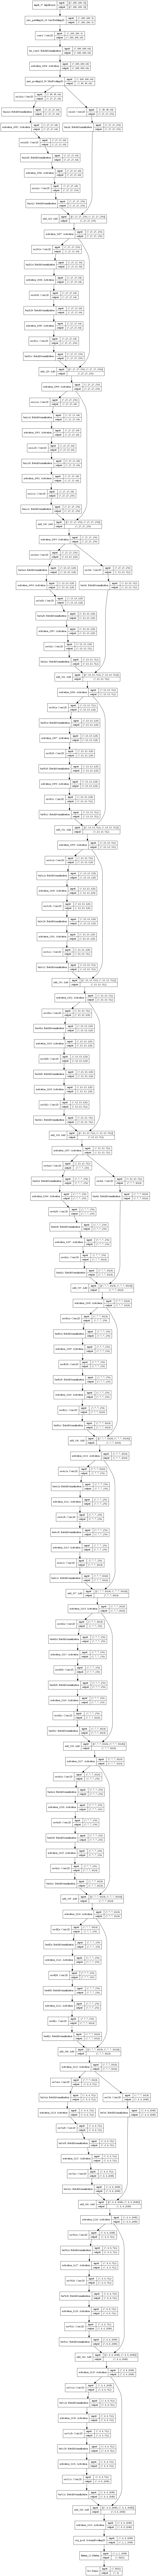

In [167]:
resnet50model = resnet50_model(input_shape=image_size+(3,), num_classes=num_classes)
keras.utils.plot_model(resnet50model, show_shapes=True)

In [168]:
epochs = 10

In [169]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_resnet50_checkpoint_{epochs}.h5')),]

resnet50model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']#, 'precision', 'recall'],
                 )

In [170]:
resnet50model.fit(train_generator,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=validation_generator,
          batch_size=batch_size)

print(resnet50model.summary())

Epoch 1/10
16/16 [==============================] - 84s 5s/step - loss: 7.5921 - accuracy: 0.8376 - val_loss: 1.3680 - val_accuracy: 0.8720
Epoch 2/10
16/16 [==============================] - 78s 5s/step - loss: 2.2305 - accuracy: 0.6931 - val_loss: 1.1019 - val_accuracy: 0.1120
Epoch 3/10
16/16 [==============================] - 81s 5s/step - loss: 1.0215 - accuracy: 0.8614 - val_loss: 0.7439 - val_accuracy: 0.8720
Epoch 4/10
16/16 [==============================] - 86s 5s/step - loss: 1.5883 - accuracy: 0.8535 - val_loss: 0.6909 - val_accuracy: 0.8720
Epoch 5/10
16/16 [==============================] - 83s 5s/step - loss: 0.6526 - accuracy: 0.8653 - val_loss: 0.5550 - val_accuracy: 0.8720
Epoch 6/10
16/16 [==============================] - 86s 5s/step - loss: 0.7394 - accuracy: 0.8653 - val_loss: 0.5404 - val_accuracy: 0.8720
Epoch 7/10
16/16 [==============================] - 89s 6s/step - loss: 0.7295 - accuracy: 0.8436 - val_loss: 0.4378 - val_accuracy: 0.8720
Epoch 8/10
16/16 [==

In [172]:
resnet50model.evaluate(validation_generator)

4/4 [==============================] - 4s 936ms/step - loss: 0.5341 - accuracy: 0.8720


[0.5341448187828064, 0.871999979019165]

In [173]:
test_generator.reset()
rn50pred = resnet50model.predict(test_generator, verbose=1)

5/5 [==============================] - 5s 970ms/step


In [174]:
rn50predicted_class_indices=np.argmax(rn50pred,axis=1)

In [176]:
rn50labels = (train_generator.class_indices)
rn50labels = dict((v,k) for k,v in rn50labels.items())
resnet50predictions = [rn50labels[k] for k in rn50predicted_class_indices]

In [177]:
rn50filenames=test_generator.filenames
resnet50results=pd.DataFrame({"Filename":rn50filenames,
                      "Predictions":resnet50predictions})
#results.to_csv("results_resnet50.csv",index=False)

In [181]:
resnet50results.Predictions.value_counts()

Impressionism    157
Name: Predictions, dtype: int64

In [ ]:
#resnet
#with pre-trained weights; see https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Network_Keras.ipynb
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [25]:
reconstructed_model = keras.models.load_model(os.path.join(modelpath,f'model_cnn_checkpoint_{epochs}.h5'))

Notes: create a test folder to evaluate; maybe use a completely independent data set? or just take a chunk out from raw images
Lessons learned:
how can we increase weights for paintings that are not as recognizable or as well known; for example other cultures - my data set only focuses on european art work - how to make this more inclusive